In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Handle constant/duplicates and missing features/columns
from feature_engine.selection import (DropFeatures, DropConstantFeatures, 
                                      DropDuplicateFeatures)

#models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,GridSearchCV



In [75]:
train_demographics = pd.read_csv("data/traindemographics.csv")
train_perf = pd.read_csv("data/trainperf.csv")
train_prevloans=pd.read_csv("data/trainprevloans.csv")

test_demographics = pd.read_csv("data/testdemographics.csv")
test_perf = pd.read_csv("data/testperf.csv")
test_prevloans=pd.read_csv("data/testprevloans.csv")

In [16]:
train_demographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [19]:
train_perf[train_perf['customerid']=='8a2a81a74ce8c05d014cfb32a0da1049'].head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good


In [24]:
train_prevloans[train_prevloans['customerid']=='8a2a81a74ce8c05d014cfb32a0da1049'].head(20)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
55,8a2a81a74ce8c05d014cfb32a0da1049,301923941,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,20000.0,24500.0,30,2017-06-25 15:24:06.000000,NaN,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000
56,8a2a81a74ce8c05d014cfb32a0da1049,301954468,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,20000.0,24500.0,30,2017-07-25 08:14:36.000000,NaN,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000
57,8a2a81a74ce8c05d014cfb32a0da1049,301777989,6,2016-12-21 19:03:40.000000,2016-12-21 11:02:54.000000,20000.0,23800.0,30,2017-02-28 13:20:29.000000,NaN,2017-01-20 00:00:00.000000,2017-02-28 13:05:11.000000
1141,8a2a81a74ce8c05d014cfb32a0da1049,301739329,4,2016-10-07 19:00:48.000000,2016-10-07 18:00:37.000000,20000.0,24500.0,30,2016-11-07 08:29:43.000000,NaN,2016-11-07 00:00:00.000000,2016-11-07 08:14:34.000000
1142,8a2a81a74ce8c05d014cfb32a0da1049,301828139,7,2017-02-28 13:25:25.000000,2017-02-28 12:25:18.000000,20000.0,23800.0,30,2017-03-01 18:25:25.000000,NaN,2017-03-30 00:00:00.000000,2017-03-01 18:10:14.000000
1742,8a2a81a74ce8c05d014cfb32a0da1049,301675247,1,2016-08-09 22:57:01.000000,2016-08-09 21:56:47.000000,10000.0,13000.0,30,2016-08-15 08:49:18.000000,NaN,2016-09-08 00:00:00.000000,2016-08-15 08:34:14.000000
1743,8a2a81a74ce8c05d014cfb32a0da1049,301705521,3,2016-09-05 08:45:24.000000,2016-09-05 07:45:16.000000,20000.0,24500.0,30,2016-10-04 18:02:58.000000,NaN,2016-10-05 00:00:00.000000,2016-10-04 17:47:49.000000


In [32]:
train_df=pd.merge(train_perf,train_demographics,how='left',on='customerid')
train_df.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary


In [33]:
print(train_demographics.shape)
print(train_perf.shape)
print(train_df.shape)

(4346, 9)
(4368, 10)
(4376, 18)


In [84]:
train_perf['good_bad_flag'].value_counts()

Good    3416
Bad      952
Name: good_bad_flag, dtype: int64

In [34]:
train_df.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary


In [43]:
X=train_df.drop(['good_bad_flag'],axis=1)
y=train_df['good_bad_flag']

In [48]:
X.dtypes.value_counts()

object     10
float64     4
int64       3
dtype: int64

In [57]:
ppl = Pipeline([
    # Step 1: Drop irrelevant columns/features
    ('drop_columns', DropFeatures(['customerid','systemloanid','loannumber'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    
    # Step 2: Impute and scale columns/features
    ('cleaning', ColumnTransformer([
        # Step 2.1: Apply steps for numerical features
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            StandardScaler()),
         make_column_selector(dtype_include='number')
        ),
        # Step 2.2 Apply steps for categorial features
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include=['category','object'])
        )])
    ),

    ('model', LogisticRegression(random_state=99))
])

In [ ]:
#lr=LogisticRegression(random_state=99)
#rf=RandomForestClassifier()
#xgb=XGBClassifier()

In [58]:
ppl_fts=ppl[0:4]
ppl_fts.fit(X,y)
features=ppl_fts.get_feature_names_out()
pd.Series(features)

0                                      num__loanamount
1                                        num__totaldue
2                                        num__termdays
3                                   num__longitude_gps
4                                    num__latitude_gps
                             ...                      
11947        cat__employment_status_clients_Unemployed
11948         cat__level_of_education_clients_Graduate
11949    cat__level_of_education_clients_Post-Graduate
11950          cat__level_of_education_clients_Primary
11951        cat__level_of_education_clients_Secondary
Length: 11952, dtype: object

Adding Hyperparameter Tuning

In [66]:
params={
    'model__class_weight': ['None','balanced']
}

clf=GridSearchCV(ppl,params,scoring='accuracy',cv=5,n_jobs=-1)
clf.fit(X,y)

c:\Users\james\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('drop_columns',
                                        DropFeatures(features_to_drop=['customerid',
                                                                       'systemloanid',
                                                                       'loannumber'])),
                                       ('drop_constant_values',
                                        DropConstantFeatures(missing_values='ignore')),
                                       ('drop_duplicates',
                                        DropDuplicateFeatures()),
                                       ('cleaning',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001FEE6F65D60>)])),
                                       ('model',
                                        LogisticRegression(random_state=99))]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['None', 'balanced']},
             scoring='accuracy')

In [69]:
clf.best_score_

0.7810786692759295

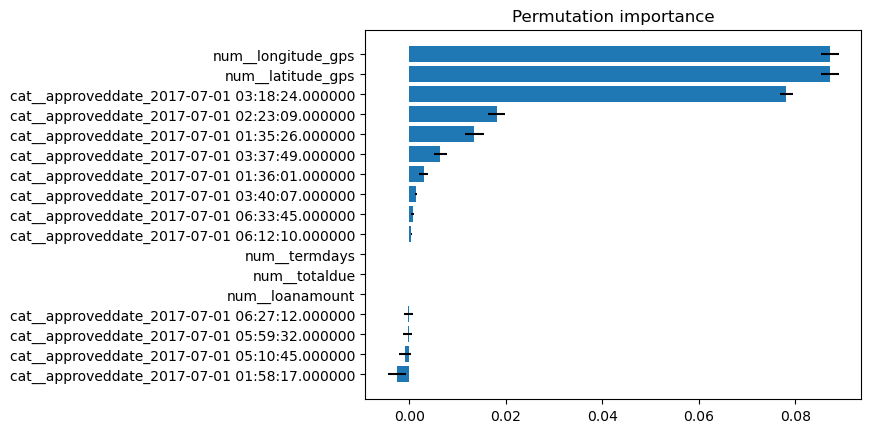

In [71]:
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """
    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])
    ax.set_yticks(range(len(indices)))
    ax.set_title("Permutation importance")
    
    tmp = np.array(feat_name)
    _ = ax.set_yticklabels(tmp[indices])

# Extract feature names after the transformation steps
# Therefore, we have to fit one part ([0:4]) of our pipeline to our data
ppl_fts = ppl[0:4]
ppl_fts.fit(X, y)
features = ppl_fts.get_feature_names_out()

# We provide the function our hyperparameter-tuned model/pipeline: clf
# In case we do not use hyperparameter tuning, we could provide here a fitted version of ppl
# For example: ppl.fit(X_train, y_train)
perm_importance_result_train = permutation_importance(clf, X, y, random_state=42)
plot_feature_importances(perm_importance_result_train, features)

# Submission

In [76]:
test_df=pd.merge(test_perf,test_demographics,how='left',on='customerid')
test_df.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,NaN,Permanent,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN,1975-08-25 00:00:00.000000,Savings,5.248368,13.059864,UBA,NaN,Permanent,NaN


In [78]:
pred_label=clf.predict(test_df)

In [82]:
pred_label.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [85]:
output=pd.DataFrame({'customerid': test_df['customerid'], 'Good_Bad_flag': pred_label})

target= {'Good':1, 'Bad':0, } 

output['Good_Bad_flag']=output['Good_Bad_flag'].replace(target)

output.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [86]:
output.to_csv('submission_20221213.csv',index=False)